In [63]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions


#scikit_optimize

In [64]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [65]:
url = "https://raw.githubusercontent.com/nutax/ai-pro1-files/main/forestfires.csv"
datos = pd.read_csv(url, sep=",")
datos.head(100)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,4,sep,sun,89.7,90.0,704.4,4.8,17.8,64,1.3,0.0,0.0
96,3,4,feb,sat,83.9,8.0,30.2,2.6,12.7,48,1.8,0.0,0.0
97,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0.0,0.0
98,3,4,aug,sun,91.4,142.4,601.4,10.6,11.6,87,4.5,0.0,0.0


In [66]:
datos.drop(datos[datos.area == 0].index, inplace=True)

In [67]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
# datos.dtypes
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 138 to 514
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       270 non-null    int64  
 1   Y       270 non-null    int64  
 2   month   270 non-null    object 
 3   day     270 non-null    object 
 4   FFMC    270 non-null    float64
 5   DMC     270 non-null    float64
 6   DC      270 non-null    float64
 7   ISI     270 non-null    float64
 8   temp    270 non-null    float64
 9   RH      270 non-null    int64  
 10  wind    270 non-null    float64
 11  rain    270 non-null    float64
 12  area    270 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 29.5+ KB


In [68]:
# Dimensiones del dataset
# ==============================================================================
datos.shape

(270, 13)

In [69]:
# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

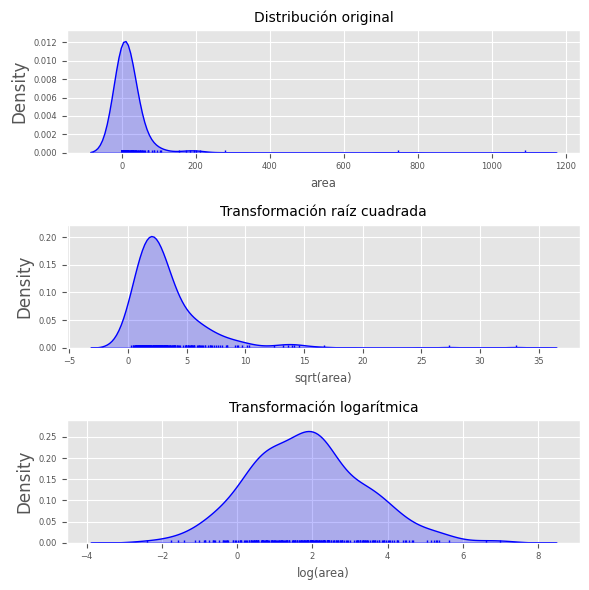

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    datos.area,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('area', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(datos.area),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(area)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

datos['area_log'] = np.log(datos.area, out=np.zeros_like(datos.area), where=(datos.area!=0))
datos.area_log
sns.distplot(
    datos['area_log'],
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(area)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()



In [71]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos.area, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.000143,2344.232665,-3890.782179,inf,0.240874,2.841927e-14
beta,0.000387,6782.163875,-3610.915260,inf,0.071552,1.199973e-01
expon,0.001083,5094.008525,-3343.934628,inf,0.336139,1.038630e-27
chi2,0.001934,1801.866921,-3181.791049,inf,0.273294,2.606623e-18
exponpow,0.002065,1680.946090,-3164.055499,inf,0.333210,3.176151e-27
powerlaw,0.002566,1568.797491,-3105.402104,inf,0.418902,1.910652e-43
norm,0.003423,6048.514771,-3033.257073,inf,0.388253,3.739751e-37
gamma,0.003961,31275.981934,-2988.207204,inf,0.958583,0.000000e+00
logistic,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos.area_log, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.312869,595.992149,-1802.912182,inf,0.041145,7.345401e-01
gamma,0.312874,593.946057,-1808.506119,inf,0.041125,7.351034e-01
chi2,0.315087,590.140921,-1806.603802,inf,0.036835,8.437711e-01
logistic,0.322543,585.652289,-1805.886875,inf,0.040478,7.524575e-01
norm,0.323874,597.932846,-1804.775026,inf,0.055028,3.734262e-01
cauchy,0.437555,589.033020,-1723.546442,inf,0.081444,5.257845e-02
powerlaw,1.186098,455.727633,-1448.698121,inf,0.274557,1.768963e-18
expon,1.601844,514.608770,-1373.165038,inf,0.338587,4.047458e-28
exponpow,6.627991,702.509706,-984.127198,inf,0.740566,1.076401e-152


In [73]:
# Variables numéricas
# ==============================================================================
datos.select_dtypes(include=['float', 'int']).describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_log
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185,1.844831
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635,1.526712
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000,-2.407946
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000,0.760806
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000,1.851598
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500,2.735823
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000,6.994703


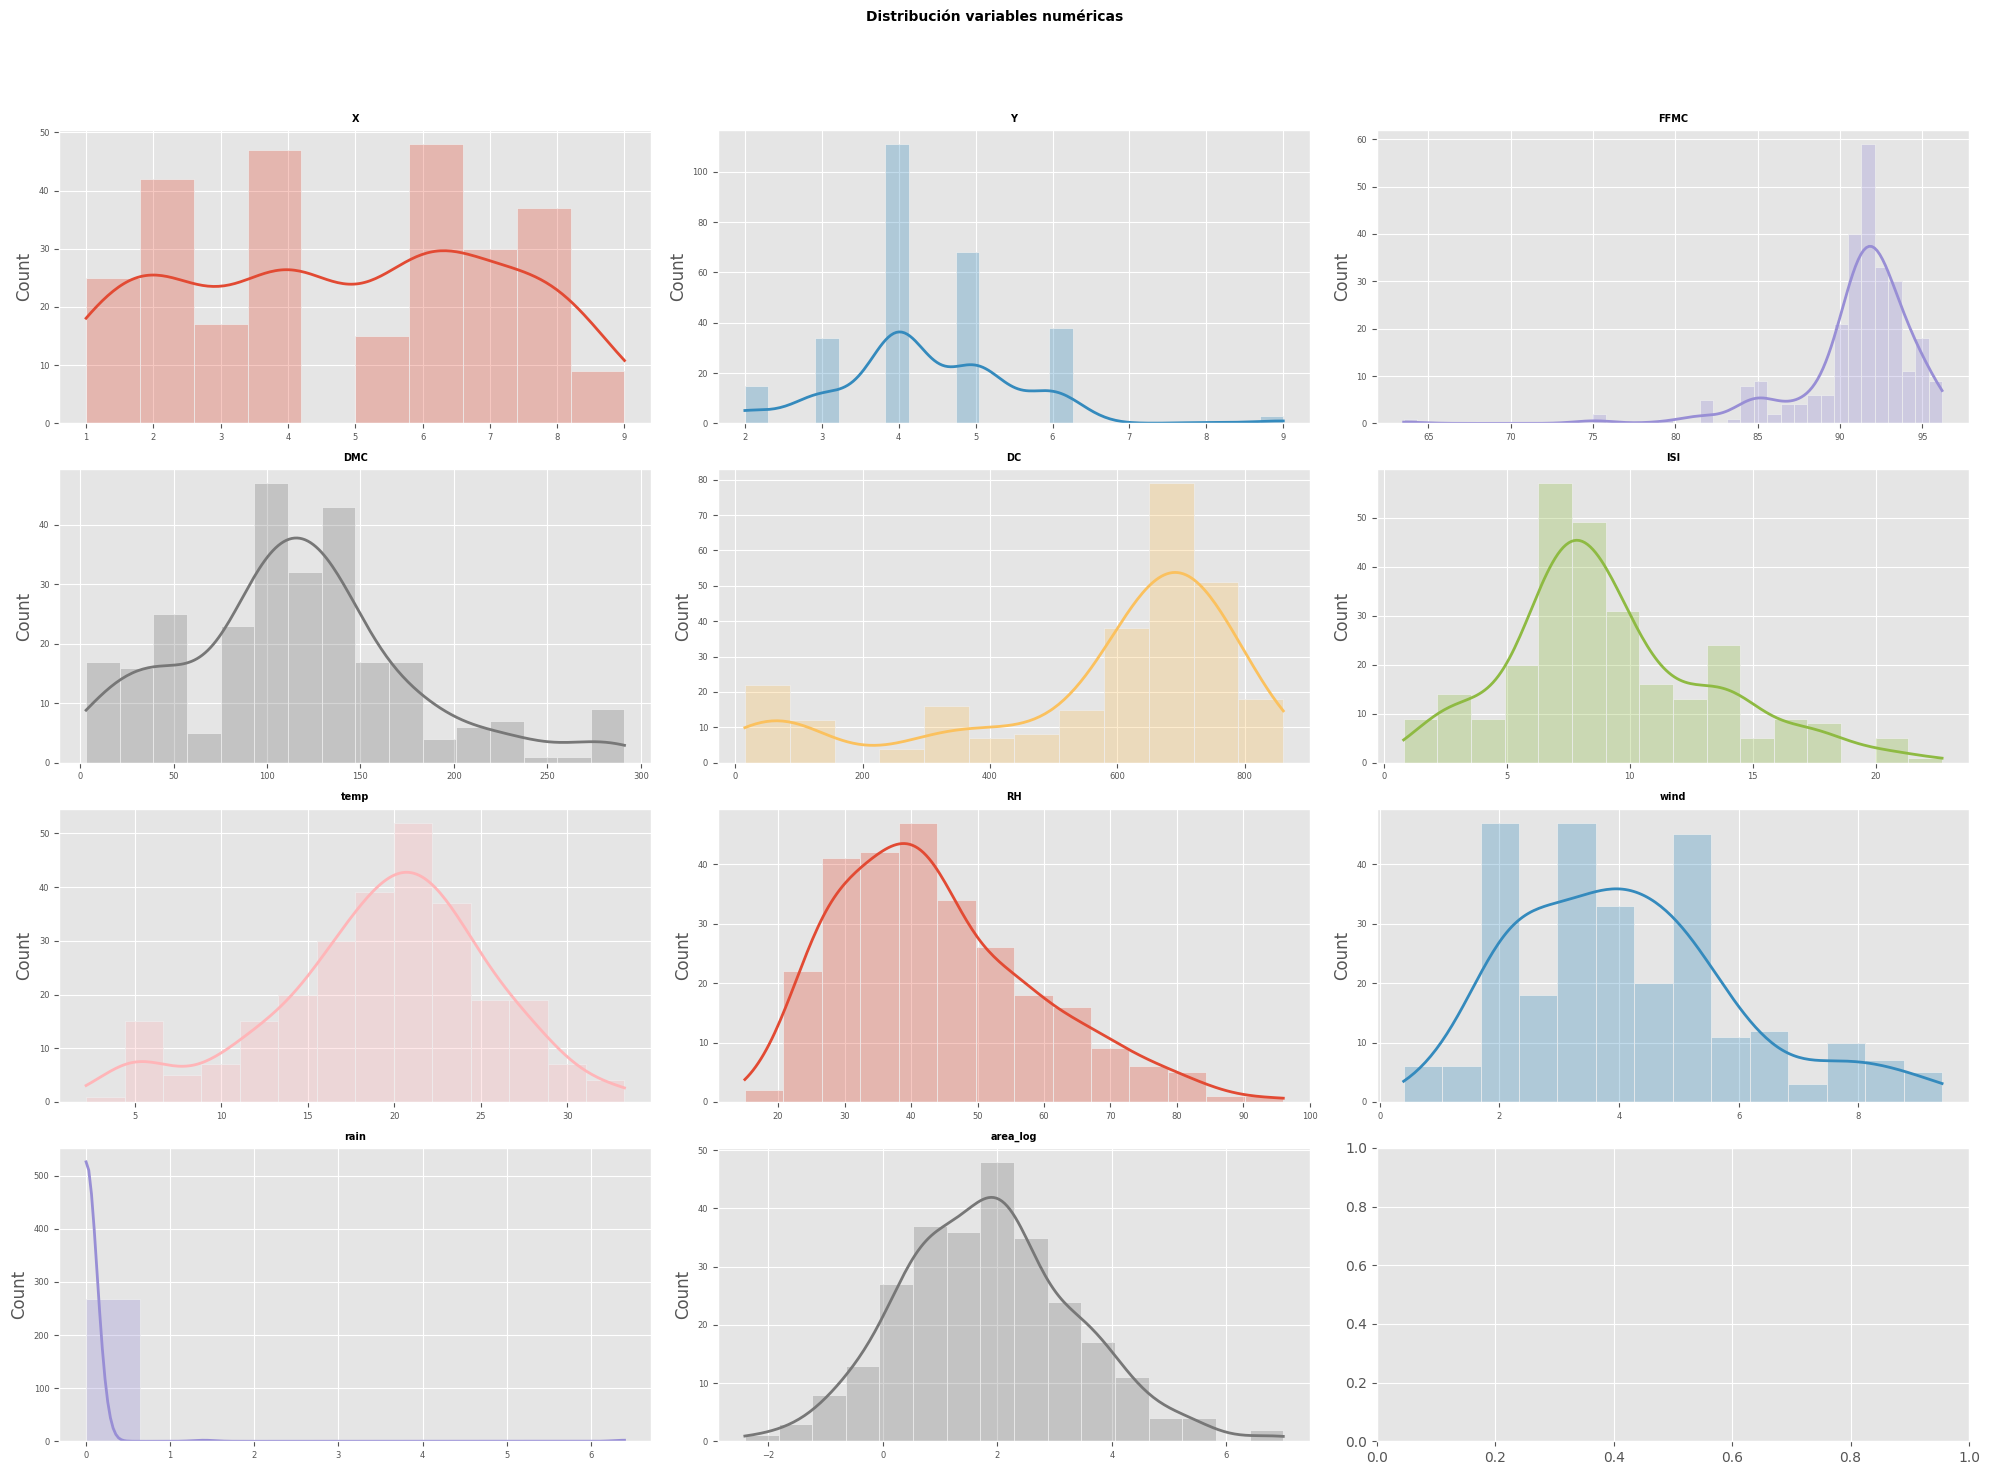

In [74]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float', 'int']).columns
columnas_numeric = columnas_numeric.drop('area')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

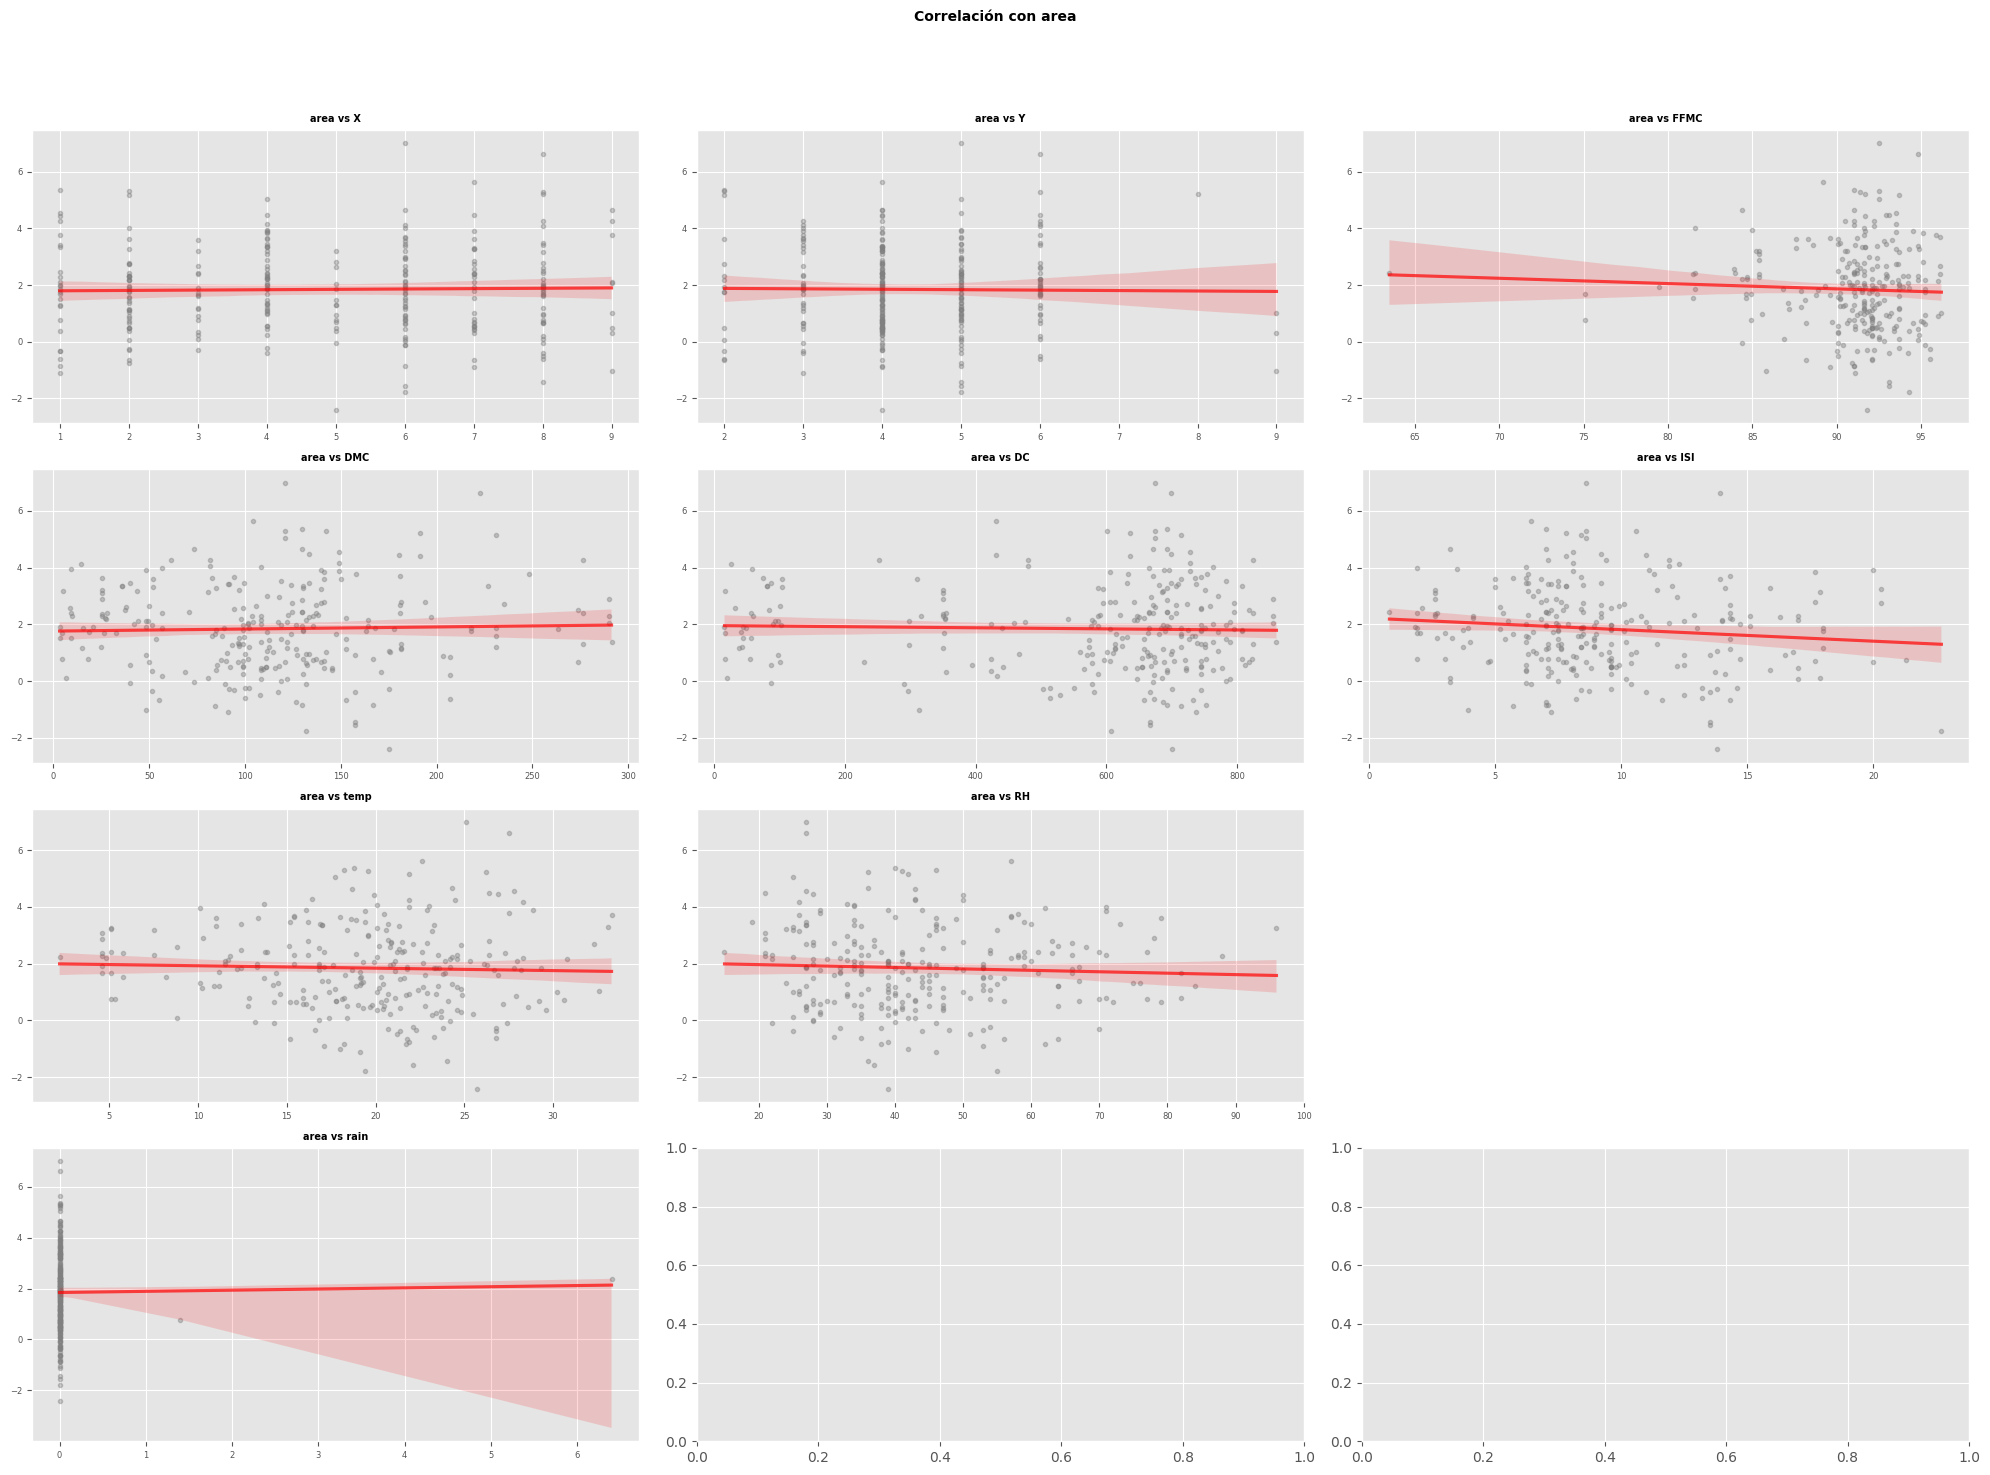

In [75]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float', 'int']).columns
columnas_numeric = columnas_numeric.drop(['area', 'area_log'])

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos[colum],
        y           =  datos.area_log,
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"area vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con area', fontsize = 10, fontweight = "bold");

In [76]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
29,FFMC,ISI,0.704170,0.704170
62,ISI,FFMC,0.704170,0.704170
51,DC,DMC,0.668926,0.668926
40,DMC,DC,0.668926,0.668926
74,temp,FFMC,0.562256,0.562256
30,FFMC,temp,0.562256,0.562256
142,area_log,area,0.533853,0.533853
131,area,area_log,0.533853,0.533853
75,temp,DMC,0.501643,0.501643
42,DMC,temp,0.501643,0.501643


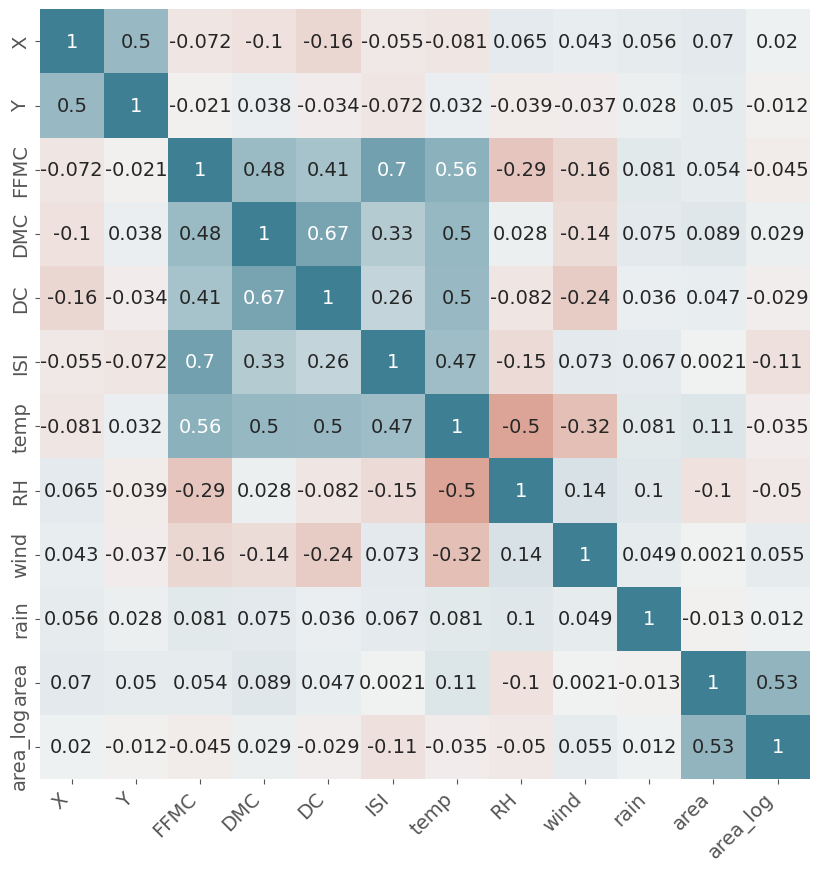

In [77]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 14},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 14)

In [78]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

,month,day
count,270,270
unique,10,7
top,aug,sun
freq,99,47


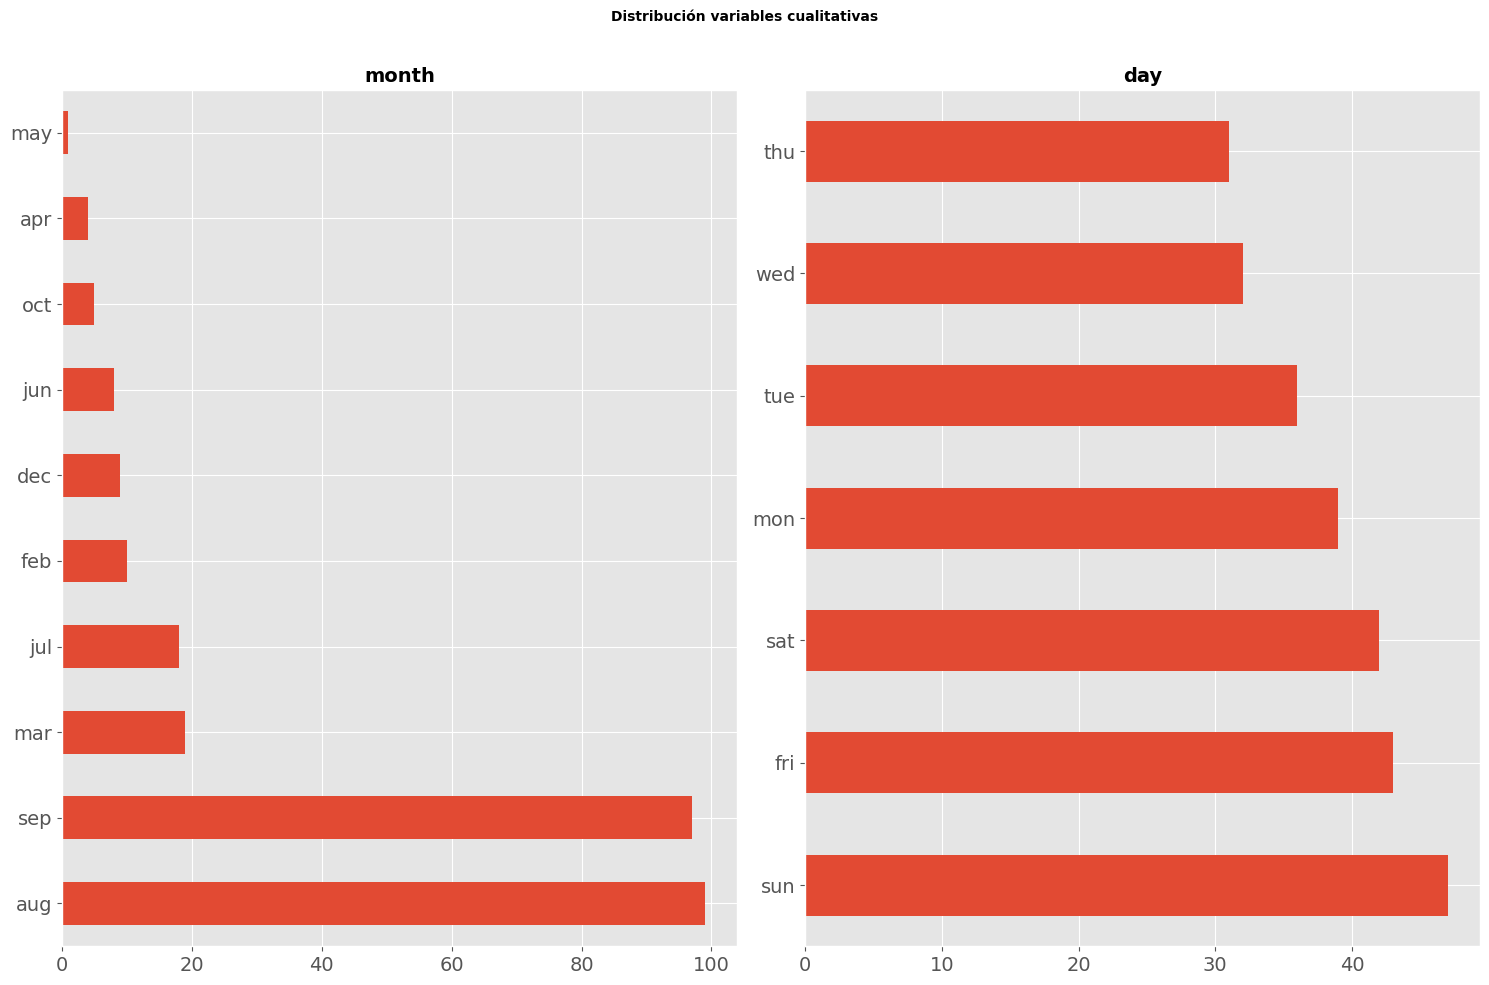

In [79]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 14)
    axes[i].set_xlabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

Podría convenir separar sep, aug, y el resto

In [87]:
dic_replace = {'apr': "resto",
               'oct': "resto",
               'jun': "resto",
               'jul': "resto",
               'dec': "resto",
               'feb': "resto",
               'jul': "resto",
               'mar': "resto",
               'may': "resto"}

datos['month_groups'] = datos['month'] \
                     .map(dic_replace) \
                     .fillna(datos['month'])

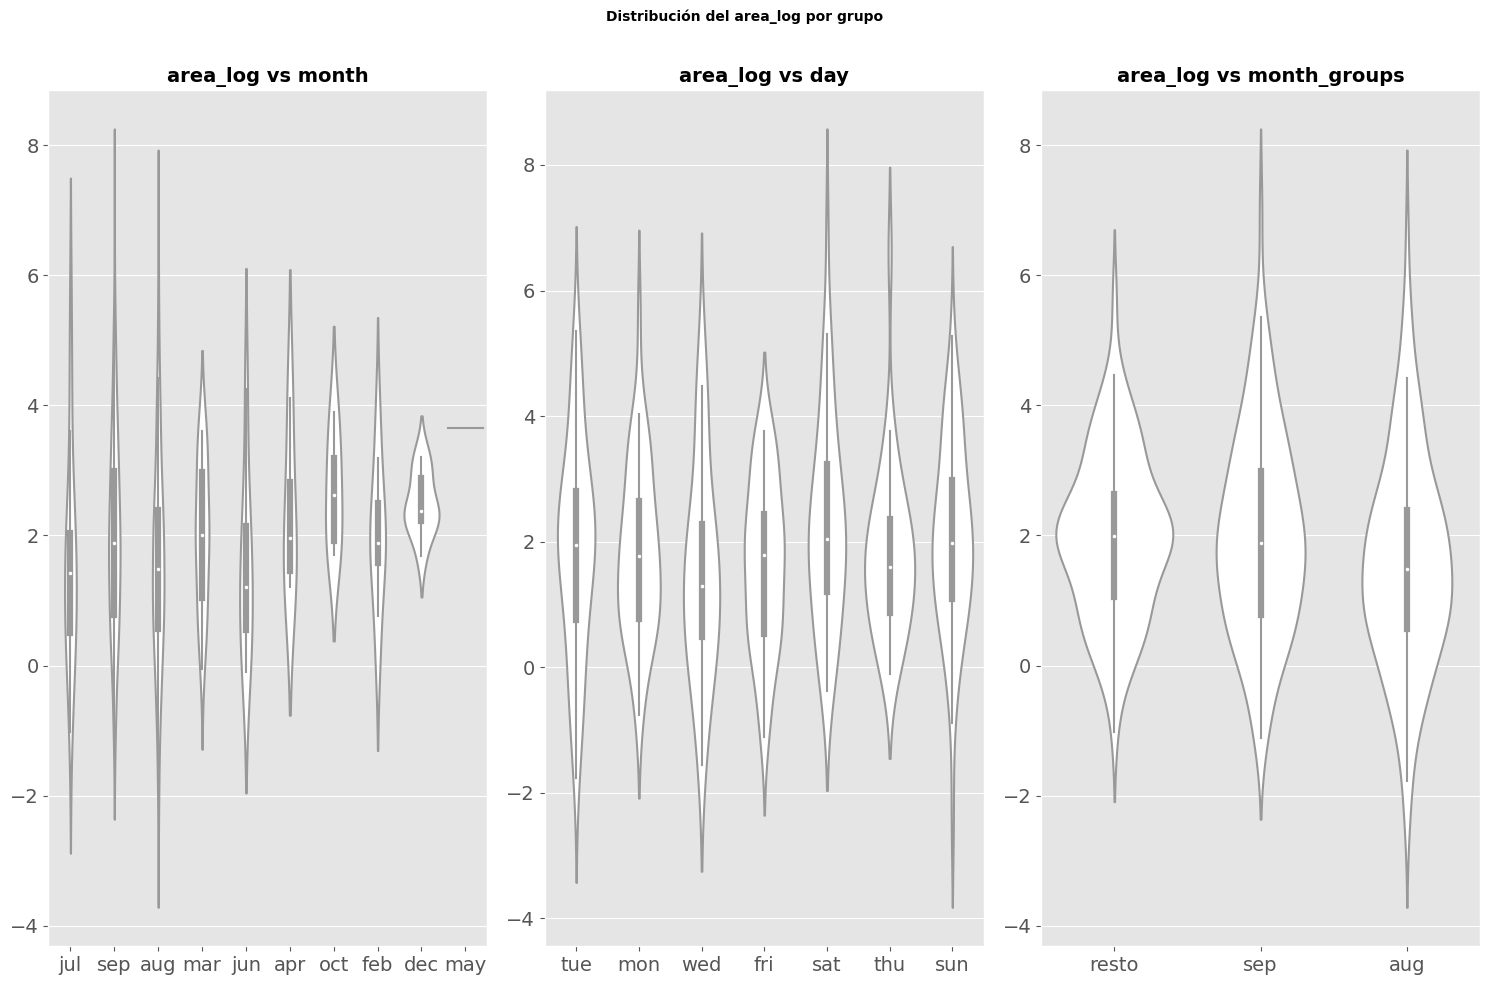

In [88]:
# Gráfico relación entre el area_log y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'area_log',
        data  = datos,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"area_log vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del area_log por grupo', fontsize = 10, fontweight = "bold");

In [89]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(['area_log', 'area'], axis = 'columns'),
                                        datos['area_log'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [90]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count    189.000000
mean       1.729066
std        1.520098
min       -1.771957
25%        0.662688
50%        1.713798
75%        2.569554
max        6.615101
Name: area_log, dtype: float64


In [91]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count    81.000000
mean      2.114949
std       1.517172
min      -2.407946
25%       1.054312
50%       2.117460
75%       2.882004
max       6.994703
Name: area_log, dtype: float64


In [98]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [99]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [100]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   X                   189 non-null    float64
 1   Y                   189 non-null    float64
 2   FFMC                189 non-null    float64
 3   DMC                 189 non-null    float64
 4   DC                  189 non-null    float64
 5   ISI                 189 non-null    float64
 6   temp                189 non-null    float64
 7   RH                  189 non-null    float64
 8   wind                189 non-null    float64
 9   rain                189 non-null    float64
 10  month_apr           189 non-null    float64
 11  month_aug           189 non-null    float64
 12  month_dec           189 non-null    float64
 13  month_feb           189 non-null    float64
 14  month_jul           189 non-null    float64
 15  month_jun           189 non-null    float64
 16  month_ma

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Pipeline
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)


In [ ]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")